✅ Loaded data shape: (5000, 7)


,tx_id,sender,receiver,amount,timestamp,type,status
0,d83a431a-9113-4340-92ea-48fbdb0e4584,0x13b1c8b0e696aff8b4fee742119b549b605f3cbc,0xd0df53e296c1e3115fccc3d7cdf4ba495e593b56,3.5726,2024-11-19 11:58:33,mint,success
1,130fdce4-991c-4fbd-be33-fec25bd15da5,0x3e69ad05716bdc834db72c4d6d44439a7c8a902b,0x4814be124d7fe3b240eb46061f7ddfab468fe122,3.1927,2023-04-28 00:47:57,mint,success
2,c906a07a-0ab6-4732-bc3f-2e70a3e098d3,0x9ad1331c5b6c5a641acffb32719c66a80c6e1a17,0x578cea5f899b0dfbf05c7fbcfda1a644b2a47787,1.6672,2023-07-15 09:18:40,transfer,success
3,5ca8f003-7711-4123-a231-07023ef79ae6,0x7399dbeebe2f88bc6ac4e3fd7ddb836a4bce322f,0x7be3dfb5b6fcbae542ea85e76cc19916a20f6c1e,2.3793,2024-01-08 18:27:36,swap,failed
4,f5465e67-4c2d-479b-af3e-9e0a03e6ccd7,0x3867d222ba91236ad4d12c31056626f9e798629c,0xded1f838ae6aa5fcd0f13481b37ee88e5bdccb3d,2.8079,2025-02-06 11:35:19,swap,success


,wallet_address,total_transactions,transaction_volume_usd,average_transaction_size,active_days,nft_activity_score,token_diversity,days_since_last_txn
0,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,40,106.1859,2.654648,40,0,31,82
1,0x06b51c6882b27cb05e712185531c1f74996dd988,45,92.3740,2.052756,45,0,39,49
2,0x0795732aacc448030ef374374eaae57d2965c16c,44,101.4789,2.306339,42,0,35,14
3,0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9,46,126.3098,2.745865,44,0,37,35
4,0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae,49,136.8461,2.792778,48,0,37,5


,wallet_address,total_transactions,transaction_volume_usd,average_transaction_size,active_days,nft_activity_score,token_diversity,days_since_last_txn
0,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,0.200000,0.265253,0.661853,0.241379,0.0,0.090909,1.000000
1,0x06b51c6882b27cb05e712185531c1f74996dd988,0.366667,0.117154,0.000000,0.413793,0.0,0.454545,0.597561
2,0x0795732aacc448030ef374374eaae57d2965c16c,0.333333,0.214782,0.278845,0.310345,0.0,0.272727,0.170732
3,0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9,0.400000,0.481032,0.762158,0.379310,0.0,0.363636,0.426829
4,0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae,0.500000,0.594008,0.813744,0.517241,0.0,0.363636,0.060976


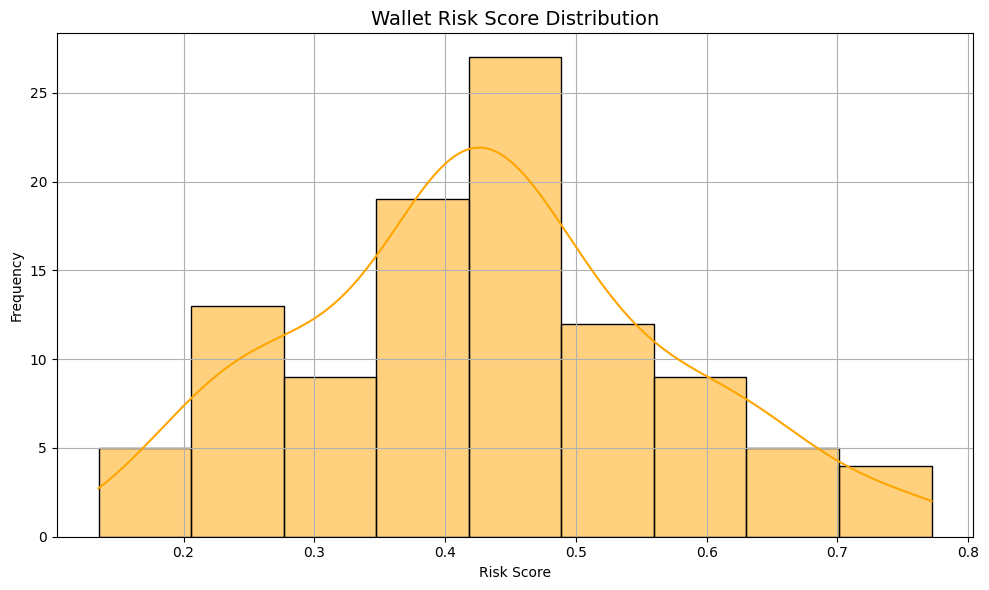

C:\Users\rushi\AppData\Local\Temp\ipykernel_10388\2939024101.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='risk_level', data=wallet_scaled, palette='Set2')


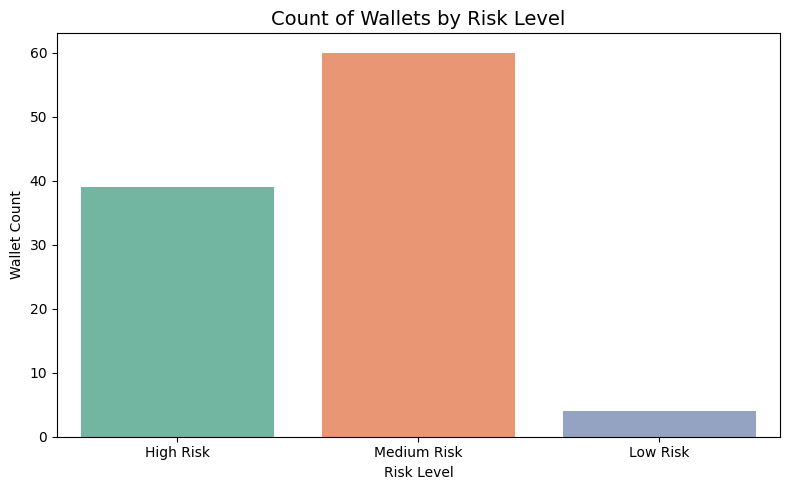

✅ Exported final scored wallet data to outputs/final_scored_wallets.csv


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

df = pd.read_csv(r"C:\Users\rushi\OneDrive\Desktop\wallet-risk-scoring\data\generated_transactions.csv")
print("✅ Loaded data shape:", df.shape)
df['timestamp'] = pd.to_datetime(df['timestamp'])  
display(df.head())

today = df['timestamp'].max()

wallet_metrics = df.groupby('sender').agg(
    total_transactions=('tx_id', 'count'),
    transaction_volume_usd=('amount', 'sum'),
    average_transaction_size=('amount', 'mean'),
    active_days=('timestamp', lambda x: x.dt.date.nunique()),
    nft_activity_score=('type', lambda x: (x == 'NFT').sum()),
    token_diversity=('receiver', 'nunique'),
    days_since_last_txn=('timestamp', lambda x: (today - x.max()).days)
).reset_index()

wallet_metrics.rename(columns={'sender': 'wallet_address'}, inplace=True)
display(wallet_metrics.head())

cols_to_scale = [
    'total_transactions', 'transaction_volume_usd', 'average_transaction_size',
    'active_days', 'nft_activity_score', 'token_diversity', 'days_since_last_txn'
]

scaler = MinMaxScaler()
scaled = pd.DataFrame(scaler.fit_transform(wallet_metrics[cols_to_scale]), columns=cols_to_scale)
wallet_scaled = pd.concat([wallet_metrics[['wallet_address']], scaled], axis=1)

display(wallet_scaled.head())

def score_wallet(row):
    score = (
        0.2 * row['total_transactions'] +
        0.2 * row['transaction_volume_usd'] +
        0.15 * row['average_transaction_size'] +
        0.1 * row['active_days'] +
        0.15 * row['nft_activity_score'] +
        0.1 * row['token_diversity'] +
        0.1 * (1 - row['days_since_last_txn'])  
    )
    return round(score, 3)

wallet_scaled['risk_score'] = wallet_scaled.apply(score_wallet, axis=1)

def assign_category(score):
    if score >= 0.7:
        return 'Low Risk'
    elif score >= 0.4:
        return 'Medium Risk'
    else:
        return 'High Risk'

wallet_scaled['risk_level'] = wallet_scaled['risk_score'].apply(assign_category)

import os
os.makedirs("outputs", exist_ok=True)

plt.figure(figsize=(10, 6))
sns.histplot(wallet_scaled['risk_score'], kde=True, color='orange')
plt.title("Wallet Risk Score Distribution", fontsize=14)
plt.xlabel("Risk Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.savefig("outputs/risk_score_distribution.png")
plt.show()

plt.figure(figsize=(8, 5))
sns.countplot(x='risk_level', data=wallet_scaled, palette='Set2')
plt.title("Count of Wallets by Risk Level", fontsize=14)
plt.xlabel("Risk Level")
plt.ylabel("Wallet Count")
plt.tight_layout()
plt.savefig("outputs/risk_level_count.png")
plt.show()

wallet_scaled.to_csv("outputs/final_scored_wallets.csv", index=False)
print("✅ Exported final scored wallet data to outputs/final_scored_wallets.csv")
